In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Deep-Flow-Prediction/

/content/drive/MyDrive/Deep-Flow-Prediction


# Supervised training for RANS flows around airfoils

## Overview 

For this example of supervised training
we have a turbulent airflow around wing profiles, and we'd like to know the average motion
and pressure distribution around this airfoil for different Reynolds numbers and angles of attack.
Thus, given an airfoil shape, Reynolds numbers, and angle of attack, we'd like to obtain
a velocity field and a pressure field around the airfoil.

This is classically approximated with _Reynolds-Averaged Navier Stokes_ (RANS) models, and this
setting is still one of the most widely used applications of Navier-Stokes solver in industry.
However, instead of relying on traditional numerical methods to solve the RANS equations,
we now aim for training a surrogate model via a neural network that completely bypasses the numerical solver,
and produces the solution in terms of velocity and pressure.



## Formulation


With the supervised formulation from `supervised`, our learning task is pretty straight-forward, and can be written as 

$$\begin{aligned}
\text{arg min}_{\theta} \sum_i ( f(x_i ; \theta)-y^*_i )^2 ,
\end{aligned}$$

where $x$ and $y^*$ each consist of a set of physical fields,
and the index $i$ evaluates the difference across all discretization points in our data sets.

The goal is to infer velocity $\mathbf{u} = u_x,u_y$ and a pressure field $p$ in a computational domain $\Omega$
around the airfoil in the center of $\Omega$. 
$u_x,u_y$ and $p$ each have a dimension of $128^2$.
As inputs we have the Reynolds number $\text{Re} \in \mathbb{R}$, the angle of attack
$\alpha \in \mathbb{R}$, and the airfoil shape $\mathbf{s}$ encoded as a rasterized grid with $128^2$.
Both constant, scalar inputs $\text{Re}$ and $\alpha$ are likewise extended to a size of $128^2$.
Thus, put together, both input and output have the same dimensions: $x,y^* \in \mathbb{R}^{3\times128\times128}$.
This is exactly what we'll specify as input and output dimensions for the NN below.

A point to keep in mind here is that our quantities of interest in $y^*$ contain three different physical fields. While the two velocity components are quite similar in spirit, the pressure field typically has a different behavior with an approximately squared scaling with respect to the velocity (cf. [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli%27s_principle)). This implies that we need to be careful with simple summations (as in the minimization problem above), and that we should take care to normalize the data.


## Code coming up...

Let's get started with the implementation. Note that we'll skip the data generation process here. The code below is adapted from {cite}`thuerey2020dfp` and [this codebase](https://github.com/thunil/Deep-Flow-Prediction), which you can check out for details. Here, we'll simply download a small set of training data generated with a Spalart-Almaras RANS simulation in [OpenFOAM](https://openfoam.org/).

In [ ]:
import numpy as np
import os.path, random
import torch
from torch.utils.data import Dataset
print("Torch version {}".format(torch.__version__))

# get training data
dir = "./"


npfile=np.load(dir+'data-airfoils.npz')
    
print("Loaded data, {} training, {} validation samples".format(len(npfile["inputs"]),len(npfile["vinputs"])))

print("Size of the inputs array: "+format(npfile["inputs"].shape))

Torch version 1.10.0+cu111
Loaded data, 320 training, 80 validation samples
Size of the inputs array: (320, 3, 128, 128)


In [ ]:
ls

data-airfoils.npz  data-airfoils-test.npz  Deep-Flow-Prediction/


If you run this notebook in colab, the `else` statement above (which is deactivated by default) might be interesting for you: instead of downloading the training data anew every time, you can manually download it once and store it in your google drive. We assume it's stored in the root directory as `data-airfoils.npz`. Afterwards, you can use the code above to load the file from your google drive, which is typically much faster. This is highly recommended if you want to experiment more extensively via colab.

## RANS training data

Now we have some training data. In general it's very important to understand the data we're working with as much as possible (for any ML task the _garbage-in-gargabe-out_ principle definitely holds). We should at least understand the data in terms of dimensions and rough statistics, but ideally also in terms of content. Otherwise we'll have a very hard time interpreting the results of a training run. And despite all the DL magic: if you can't make out any patterns in your data, NNs surely won't find any useful ones.

Hence, let's look at one of the training samples... The following is just some helper code to show images side by side.

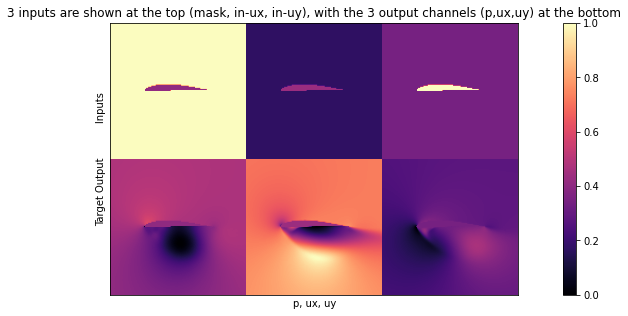

In [ ]:
import pylab

# helper to show three target channels: normalized, with colormap, side by side
def showSbs(a1,a2, stats=False, bottom="NN Output", top="Reference", title=None): 
  c=[]
  for i in range(3):
    b = np.flipud( np.concatenate((a2[i],a1[i]),axis=1).transpose())
    min, mean, max = np.min(b), np.mean(b), np.max(b); 
    if stats: print("Stats %d: "%i + format([min,mean,max]))
    b -= min; b /= (max-min)
    c.append(b)
  fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
  axes.set_xticks([]); axes.set_yticks([]); 
  im = axes.imshow(np.concatenate(c,axis=1), origin='upper', cmap='magma')

  pylab.colorbar(im); pylab.xlabel('p, ux, uy'); pylab.ylabel('%s           %s'%(bottom,top))
  if title is not None: pylab.title(title)

NUM=72
showSbs(npfile["inputs"][NUM],npfile["targets"][NUM], stats=False, bottom="Target Output", top="Inputs", title="3 inputs are shown at the top (mask, in-ux, in-uy), with the 3 output channels (p,ux,uy) at the bottom")


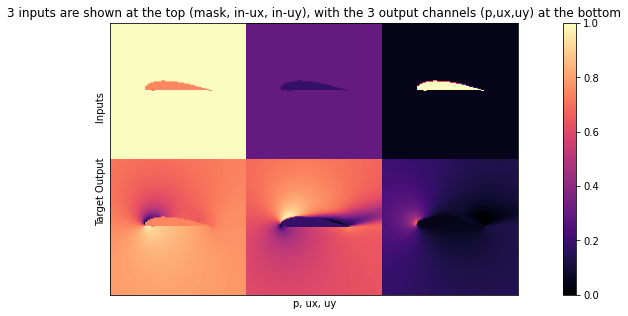

In [ ]:
NUM=70
showSbs(npfile["inputs"][NUM],npfile["targets"][NUM], stats=False, bottom="Target Output", top="Inputs", title="3 inputs are shown at the top (mask, in-ux, in-uy), with the 3 output channels (p,ux,uy) at the bottom")


In [ ]:
npfile["inputs"].shape,npfile["targets"].shape,npfile["vinputs"].shape

((320, 3, 128, 128), (320, 3, 128, 128), (80, 3, 128, 128))

Next, let's define a small helper class `DfpDataset` to organize inputs and targets. We'll transfer the corresponding data to the pytorch `DataLoader` class. 

We also set up some globals to control training parameters, maybe most importantly: the learning rate `LR`, i.e. $\eta$ from the previous setions. When your training run doesn't converge this is the first parameter to experiment with.

Here, we'll keep it relatively small throughout. (Using _learning rate decay_ would be better, i.e. potentially give an improved convergence, but is omitted here for clarity.) 

In [ ]:
# some global training constants

# number of training epochs
EPOCHS = 100
# batch size
BATCH_SIZE = 10
# learning rate
LR = 0.00002

class DfpDataset():
    def __init__(self, inputs,targets): 
        self.inputs  = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

tdata = DfpDataset(npfile["inputs"],npfile["targets"])
vdata = DfpDataset(npfile["vinputs"],npfile["vtargets"])

trainLoader = torch.utils.data.DataLoader(tdata, batch_size=BATCH_SIZE, shuffle=True , drop_last=True) 
valiLoader  = torch.utils.data.DataLoader(vdata, batch_size=BATCH_SIZE, shuffle=False, drop_last=True) 

print("Training & validation batches: {} , {}".format(len(trainLoader),len(valiLoader) ))

Training & validation batches: 32 , 8


## Network setup

Now we can set up the architecture of our neural network, we'll use a fully convolutional U-net. This is a widely used architecture that uses a stack of convolutions across different spatial resolutions. The main deviation from a regular conv-net is to introduce _skip connection_ from the encoder to the decoder part. This ensures that no information is lost during feature extraction. (Note that this only works if the network is to be used as a whole. It doesn't work in situations where we'd, e.g., want to use the decoder as a standalone component.)

Here's a overview of the architecure:

![An overview of the U-net we're using for this learning task](https://github.com/tum-pbs/pbdl-book/blob/main/resources/supervised-airfoils-unet.jpg?raw=1)

First, we'll define a helper to set up a convolutional block in the network, `blockUNet`. Note, we don't use any pooling! Instead we use strides and transpose convolutions (these need to be symmetric for the decoder part, i.e. have an uneven kernel size), following [best practices](https://distill.pub/2016/deconv-checkerboard/). The full pytroch neural network is managed via the `DfpNet` class.

In [ ]:
import os, sys, random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd 
import torch.utils.data 

def blockUNet(in_c, out_c, name, size=4, pad=1, transposed=False, bn=True, activation=True, relu=True, dropout=0. ):
    block = nn.Sequential()

    if not transposed:
        block.add_module('%s_conv' % name, nn.Conv2d(in_c, out_c, kernel_size=size, stride=2, padding=pad, bias=True))
    else:
        block.add_module('%s_upsam' % name, nn.Upsample(scale_factor=2, mode='bilinear'))
        # reduce kernel size by one for the upsampling (ie decoder part)
        block.add_module('%s_tconv' % name, nn.Conv2d(in_c, out_c, kernel_size=(size-1), stride=1, padding=pad, bias=True))

    if bn:
        block.add_module('%s_bn' % name, nn.BatchNorm2d(out_c))
    if dropout>0.:
        block.add_module('%s_dropout' % name, nn.Dropout2d( dropout, inplace=True))

    if activation:
        if relu:
            block.add_module('%s_relu' % name, nn.ReLU(inplace=True))
        else:
            block.add_module('%s_leakyrelu' % name, nn.LeakyReLU(0.2, inplace=True))

    return block
    
class DfpNet(nn.Module):
    def __init__(self, channelExponent=6, dropout=0.):
        super(DfpNet, self).__init__()
        channels = int(2 ** channelExponent + 0.5)

        self.layer1 = blockUNet(3         , channels*1, 'enc_layer1', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer2 = blockUNet(channels  , channels*2, 'enc_layer2', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer3 = blockUNet(channels*2, channels*2, 'enc_layer3', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer4 = blockUNet(channels*2, channels*4, 'enc_layer4', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer5 = blockUNet(channels*4, channels*8, 'enc_layer5', transposed=False, bn=True, relu=False, dropout=dropout ) 
        self.layer6 = blockUNet(channels*8, channels*8, 'enc_layer6', transposed=False, bn=True, relu=False, dropout=dropout , size=2,pad=0)
        self.layer7 = blockUNet(channels*8, channels*8, 'enc_layer7', transposed=False, bn=True, relu=False, dropout=dropout , size=2,pad=0)
     
        # note, kernel size is internally reduced by one for the decoder part
        self.dlayer7 = blockUNet(channels*8, channels*8, 'dec_layer7', transposed=True, bn=True, relu=True, dropout=dropout , size=2,pad=0)
        self.dlayer6 = blockUNet(channels*16,channels*8, 'dec_layer6', transposed=True, bn=True, relu=True, dropout=dropout , size=2,pad=0)
        self.dlayer5 = blockUNet(channels*16,channels*4, 'dec_layer5', transposed=True, bn=True, relu=True, dropout=dropout ) 
        self.dlayer4 = blockUNet(channels*8, channels*2, 'dec_layer4', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer3 = blockUNet(channels*4, channels*2, 'dec_layer3', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer2 = blockUNet(channels*4, channels  , 'dec_layer2', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer1 = blockUNet(channels*2, 3         , 'dec_layer1', transposed=True, bn=False, activation=False, dropout=dropout )

    def forward(self, x):
        # note, this Unet stack could be allocated with a loop, of course... 
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)
        out6 = self.layer6(out5)
        out7 = self.layer7(out6)
        # ... bottleneck ...
        dout6 = self.dlayer7(out7)
        dout6_out6 = torch.cat([dout6, out6], 1)
        dout6 = self.dlayer6(dout6_out6)
        dout6_out5 = torch.cat([dout6, out5], 1)
        dout5 = self.dlayer5(dout6_out5)
        dout5_out4 = torch.cat([dout5, out4], 1)
        dout4 = self.dlayer4(dout5_out4)
        dout4_out3 = torch.cat([dout4, out3], 1)
        dout3 = self.dlayer3(dout4_out3)
        dout3_out2 = torch.cat([dout3, out2], 1)
        dout2 = self.dlayer2(dout3_out2)
        dout2_out1 = torch.cat([dout2, out1], 1)
        dout1 = self.dlayer1(dout2_out1)
        return dout1

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


Next, we can initialize an instance of the `DfpNet`.

Below, the `EXPO` parameter here controls the exponent for the feature maps of our Unet: this directly scales the network size (3 gives a network with ca. 150k parameters). This is relatively small for a generative NN with $3 \times 128^2 = \text{ca. }49k$ outputs, but yields fast training times and prevents overfitting given the relatively small data set we're using here. Hence it's a good starting point.

In [ ]:
# channel exponent to control network size
EXPO = 3

# setup network
net = DfpNet(channelExponent=EXPO)
#print(net) # to double check the details...

nn_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in nn_parameters])

# crucial parameter to keep in view: how many parameters do we have?
print("Trainable params: {}   -> crucial! always keep in view... ".format(params)) 

net.apply(weights_init)

criterionL1 = nn.L1Loss()
optimizerG = optim.Adam(net.parameters(), lr=LR, betas=(0.5, 0.999), weight_decay=0.0)

targets = torch.autograd.Variable(torch.FloatTensor(BATCH_SIZE, 3, 128, 128))
inputs  = torch.autograd.Variable(torch.FloatTensor(BATCH_SIZE, 3, 128, 128))


Trainable params: 147363   -> crucial! always keep in view... 


With an exponent of 3, this network has 147555 trainable parameters. As the subtle hint in the print statement indicates, this is a crucial number to always have in view when training NNs. It's easy to change settings, and get a network that has millions of parameters, and as a result probably all kinds of convergence and overfitting problems. The number of parameters definitely has to be matched with the amount of training data, and should also scale with the depth of the network. How these three relate to each other exactly is problem dependent, though.

## Training

Finally, we can train the NN. This step can take a while, as the training runs over all 320 samples 100 times, and continually evaluates the validation samples to keep track of how well the current state of the NN is doing.

In [ ]:
history_L1 = []
history_L1val = []

if os.path.isfile("network"):
  print("Found existing network, loading & skipping training")
  net.load_state_dict(torch.load("network")) # optionally, load existing network

else:
  print("Training from scratch")
  for epoch in range(EPOCHS):
      net.train()
      L1_accum = 0.0
      for i, traindata in enumerate(trainLoader, 0):
          inputs_curr, targets_curr = traindata
          inputs.data.copy_(inputs_curr.float())
          targets.data.copy_(targets_curr.float())

          net.zero_grad()
          gen_out = net(inputs)

          lossL1 = criterionL1(gen_out, targets)
          lossL1.backward()
          optimizerG.step()
          L1_accum += lossL1.item()

      # validation
      net.eval()
      L1val_accum = 0.0
      for i, validata in enumerate(valiLoader, 0):
          inputs_curr, targets_curr = validata
          inputs.data.copy_(inputs_curr.float())
          targets.data.copy_(targets_curr.float())

          outputs = net(inputs)
          outputs_curr = outputs.data.cpu().numpy()

          lossL1val = criterionL1(outputs, targets)
          L1val_accum += lossL1val.item()

      # data for graph plotting
      history_L1.append( L1_accum / len(trainLoader) )
      history_L1val.append( L1val_accum / len(valiLoader) )

      if epoch<3 or epoch%20==0:
          print( "Epoch: {}, L1 train: {:7.5f}, L1 vali: {:7.5f}".format(epoch, history_L1[-1], history_L1val[-1]) )

  torch.save(net.state_dict(), "network" )
  print("Training done, saved network")


Training from scratch


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Epoch: 0, L1 train: 0.19521, L1 vali: 0.20978
Epoch: 1, L1 train: 0.17094, L1 vali: 0.17599
Epoch: 2, L1 train: 0.15678, L1 vali: 0.14967
Epoch: 20, L1 train: 0.04828, L1 vali: 0.03593
Epoch: 40, L1 train: 0.03817, L1 vali: 0.02873
Epoch: 60, L1 train: 0.03358, L1 vali: 0.02655
Epoch: 80, L1 train: 0.03190, L1 vali: 0.02471
Training done, saved network


The NN is finally trained! The losses should have nicely gone down in terms of absolute values: With the standard settings from an initial value of around 0.2 for the validation  loss, to ca. 0.02 after 100 epochs. 

Let's look at the graphs to get some intuition for how the training progressed over time. This is typically important to identify longer-term trends in the training. In practice it's tricky to spot whether the overall trend of 100 or so noisy numbers in a command line log is going slightly up or down - this is much easier to spot in a visualization.

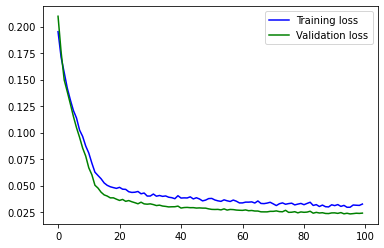

In [ ]:
import matplotlib.pyplot as plt

l1train = np.asarray(history_L1)
l1vali  = np.asarray(history_L1val)

plt.plot(np.arange(l1train.shape[0]),l1train,'b',label='Training loss')
plt.plot(np.arange(l1vali.shape[0] ),l1vali ,'g',label='Validation loss')
plt.legend()
plt.show()


You should see a curve that goes down for ca. 40 epochs, and then starts to flatten out. In the last part, it's still slowly decreasing, and most importantly, the validation loss is not increasing. This would be a certain sign of overfitting, and something that we should avoid. (Try decreasing the amount of training data artificially, then you should be able to intentionally cause overfitting.)

## Training progress and validation

If you look closely at this graph, you should spot something peculiar:
_Why is the validation loss lower than the training loss_?
The data is similar to the training data of course, but in a way it's slightly "tougher", because the network certainly never received any validation samples during training. It is natural that the validation loss slightly deviates from the training loss, but how can the L1 loss be _lower_ for these inputs?

This is a subtlety of the training loop above: it runs a training step first, and the loss for each point in the graph is measured with the evolving state of the network in an epoch. The network is updated, and afterwards runs through the validation samples. Thus all validation samples are using a state that is definitely different (and hopefully a bit better) than the initial states of the epoch. Hence, the validation loss can be slightly lower.

A general word of caution here: never evaluate your network with training data! That won't tell you much because overfitting is a very common problem. At least use data the network hasn't seen before, i.e. validation data, and if that looks good, try some more different (at least slightly out-of-distribution) inputs, i.e., _test data_. The next cell runs the trained network over the validation data, and displays one of them with the `showSbs` function.



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


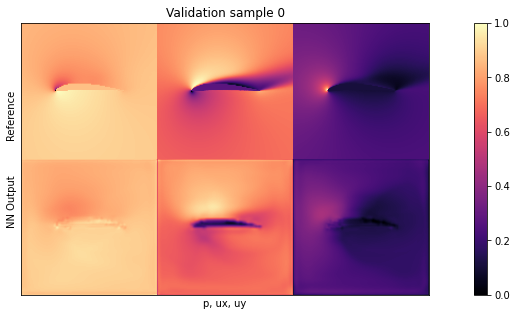

In [ ]:
net.eval()
for i, validata in enumerate(valiLoader, 0):
    inputs_curr, targets_curr = validata
    inputs.data.copy_(inputs_curr.float())
    targets.data.copy_(targets_curr.float())
    
    outputs = net(inputs)
    outputs_curr = outputs.data.cpu().numpy()
    if i<1: showSbs(targets_curr[0] , outputs_curr[0], title="Validation sample %d"%(i*BATCH_SIZE))


Visually, there should at least be a rough resemblance here between input out network output. We'll save the more detailed evaluation for the test data, though.

## Test evaluation

Now let's look at actual test samples: In this case we'll use new airfoil shapes as out-of-distribution (OOD) data. These are shapes that the network never saw in any training samples, and hence it tells us a bit about how well the NN generalizes to unseen inputs (the validation data wouldn't suffice to draw conclusions about generalization).

We'll use the same visualization as before, and as indicated by the Bernoulli equation, especially the _pressure_ in the first column is a challenging quantity for the network. Due to it's cubic scaling w.r.t. the input freestream velocity and localized peaks, it is the toughest quantity to infer for the network.

The cell below first downloads a smaller archive with these test data samples, and then runs them through the network. The evaluation loop also computes the accumulated L1 error such that we can quantify how well the network does on the test samples.

Loaded 10/10 test samples



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



Average test error: 0.0327878437936306


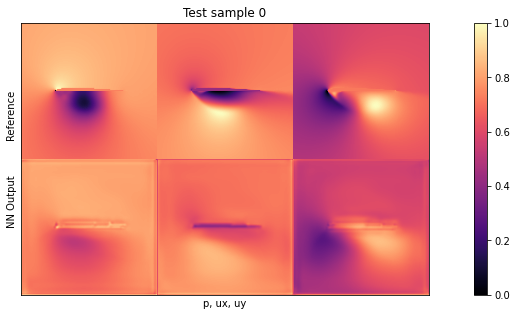

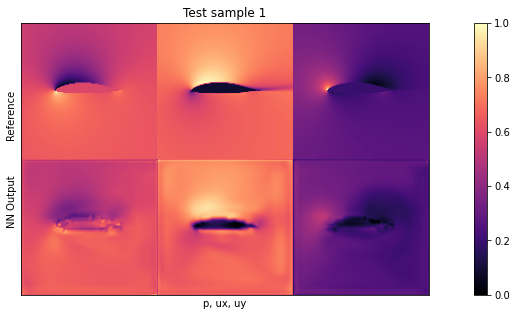

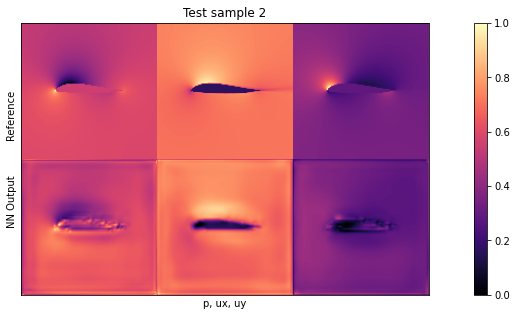

In [ ]:
nptfile=np.load('data-airfoils-test.npz')
print("Loaded {}/{} test samples\n".format(len(nptfile["test_inputs"]),len(nptfile["test_targets"])))

testdata = DfpDataset(nptfile["test_inputs"],nptfile["test_targets"])
testLoader  = torch.utils.data.DataLoader(testdata, batch_size=1, shuffle=False, drop_last=True) 

net.eval()
L1t_accum = 0.
for i, validata in enumerate(testLoader, 0):
    inputs_curr, targets_curr = validata
    inputs.data.copy_(inputs_curr.float())
    targets.data.copy_(targets_curr.float())

    outputs = net(inputs)
    outputs_curr = outputs.data.cpu().numpy()

    lossL1t = criterionL1(outputs, targets)
    L1t_accum += lossL1t.item()
    if i<3: showSbs(targets_curr[0] , outputs_curr[0],  title="Test sample %d"%(i))

print("\nAverage test error: {}".format( L1t_accum/len(testLoader) ))

The average test error with the default settings should be ca. 0.03. As the inputs are normalized, this means the average error across all three fields is 3% w.r.t. the maxima of each quantity. This is not too bad for new shapes, but clearly leaves room for improvement.

Looking at the visualizations, you'll notice that especially high-pressure peaks and pockets of larger y-velocities are missing in the outputs. This is primarily caused by the small network, which does not have enough resources to reconstruct details.

Nonetheless, we have successfully replaced a fairly sophisticated RANS solver with a very small and fast neural network architecture. It has GPU support "out-of-the-box" (via pytorch), is differentiable, and introduces an error of only a few per-cent.

---




## Next steps

There are many obvious things to try here (see the suggestions below), e.g. longer training, larger data sets, larger networks etc. 

* Experiment with learning rate, dropout, and network size to reduce the error on the test set. How small can you make it with the given training data?

* The setup above uses normalized data. Instead you can recover [the original fields by undoing the normalization](https://github.com/thunil/Deep-Flow-Prediction) to check how well the network does w.r.t. the original quantities.

* As you'll see, it's a bit limited here what you can get out of this dataset, head over to [the main github repo of this project](https://github.com/thunil/Deep-Flow-Prediction) to download larger data sets, or generate own data.

